# Pose Reward Pipeline Visualization

This notebook provides simple visualization of pose validity rewards.
The actual reward computation is handled by `pose_reward.py`.


In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

notebook_dir = os.getcwd()
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

from pose_reward import PoseValidityReward


/opt/homebrew/Caskroom/miniconda/base/envs/291/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize reward function
reward_fn = PoseValidityReward(
    vae_model_path=None,
    device="cpu"
)
print("✓ Reward function initialized")


Loading ViTPose...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ViTPose loaded
Loading VAE model from /Users/cj/Desktop/291 project/Fk-Diffusion-Steering-main/swimming_pose_reward/pose_vae_side_swimming.pt...
Standardization parameters loaded from model file
VAE model loaded and ready
✓ Reward function initialized


In [3]:
# Find test images
notebook_dir = os.getcwd()
test_dir = os.path.join(notebook_dir, "dataset", "swimming_test")

image_patterns = ["*.jpg", "*.jpeg", "*.png", "*.webp"]
image_paths = []
for pattern in image_patterns:
    image_paths.extend(
        glob.glob(os.path.join(test_dir, "**", pattern), recursive=True)
    )
image_paths = sorted(set(image_paths))

print(f"Found {len(image_paths)} test images")
print(f"Searching in: {test_dir}")


Found 17 test images
Searching in: /Users/cj/Desktop/291 project/Fk-Diffusion-Steering-main/swimming_pose_reward/dataset/swimming_test


In [4]:
# Process all images and collect results
results = []

for img_path in image_paths:
    reward, recon_loss, success, keypoints_dict = reward_fn.compute_reward(img_path)

    if success:
        results.append({
            'path': img_path,
            'reward': reward,
            'recon_loss': recon_loss,
            'keypoints': keypoints_dict
        })
    else:
        print(f"Failed to process: {img_path}")

print(f"Processed {len(results)} images successfully")


Processed 17 images successfully


In [5]:
# Sort by reward (highest = best pose)
results.sort(key=lambda x: x['reward'], reverse=True)

print("Results sorted by reward (highest = best pose):")
print("=" * 100)
for i, r in enumerate(results, 1):
    filename = os.path.basename(r['path'])
    print(f"{i:2d}. {filename:50s} | Reward: {r['reward']:7.4f} | Recon: {r['recon_loss']:.6f}")

# Statistics
rewards = [r['reward'] for r in results]
recon_losses = [r['recon_loss'] for r in results]

print(f"\nStatistics:")
print(f"  Reward range: [{min(rewards):.4f}, {max(rewards):.4f}]")
print(f"  Reward mean: {np.mean(rewards):.4f} ± {np.std(rewards):.4f}")
print(f"  Recon loss range: [{min(recon_losses):.6f}, {max(recon_losses):.6f}]")
print(f"  Recon loss mean: {np.mean(recon_losses):.6f} ± {np.std(recon_losses):.6f}")


Results sorted by reward (highest = best pose):
 1. 1.png                                              | Reward: -0.3219 | Recon: 0.321919
 2. Freestyle Stroke.png                               | Reward: -0.3565 | Recon: 0.356503
 3. myswimpro-freestyle-fares-01.png                   | Reward: -0.5433 | Recon: 0.543343
 4. Gemini_Generated_Image_p54cwip54cwip54c.png        | Reward: -0.5568 | Recon: 0.556802
 5. Nike-Swim-Underwater-Freestyle.jpg                 | Reward: -0.6616 | Recon: 0.661642
 6. 2.png                                              | Reward: -0.6670 | Recon: 0.667038
 7. Gemini_Generated_Image_ccy58vccy58vccy5.png        | Reward: -0.7754 | Recon: 0.775360
 8. 4.png                                              | Reward: -0.8418 | Recon: 0.841826
 9. 8037-swim.jpg                                      | Reward: -0.9014 | Recon: 0.901437
10. Gemini_Generated_Image_5cdfyr5cdfyr5cdf.png        | Reward: -0.9299 | Recon: 0.929902
11. Gemini_Generated_Image_53tlkc53tlkc53t

In [6]:
def visualize_image_with_reward(image_path, reward, recon_loss, keypoints_dict, ax):
    """Visualize image with keypoints and reward value."""
    image = Image.open(image_path).convert('RGB')
    ax.imshow(image)
    ax.axis('off')

    # draw keypoints
    if keypoints_dict:
        name_map = {
            'l_shoulder': 'LSh', 'r_shoulder': 'RSh',
            'l_elbow': 'LEl', 'r_elbow': 'REl',
            'l_wrist': 'LWi', 'r_wrist': 'RWi',
            'l_hip': 'LHi', 'r_hip': 'RHi',
            'l_knee': 'LKn', 'r_knee': 'RKn',
            'l_ankle': 'LAn', 'r_ankle': 'RAn'
        }
        for name, kp in keypoints_dict.items():
            x, y = kp[0], kp[1]
            ax.plot(x, y, 'ro', markersize=5, markeredgecolor='darkred', markeredgewidth=0.5)
            label = name_map.get(name, name.split('_')[1][:3])
            ax.text(x+5, y+5, label, fontsize=7, color='red',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.3,
                           edgecolor='red', linewidth=0.5))

    filename = os.path.basename(image_path)
    ax.set_title(f"{filename}\nReward: {reward:.4f} | Recon: {recon_loss:.4f}",
                 fontsize=9, pad=5)


Top 6 results (best poses):


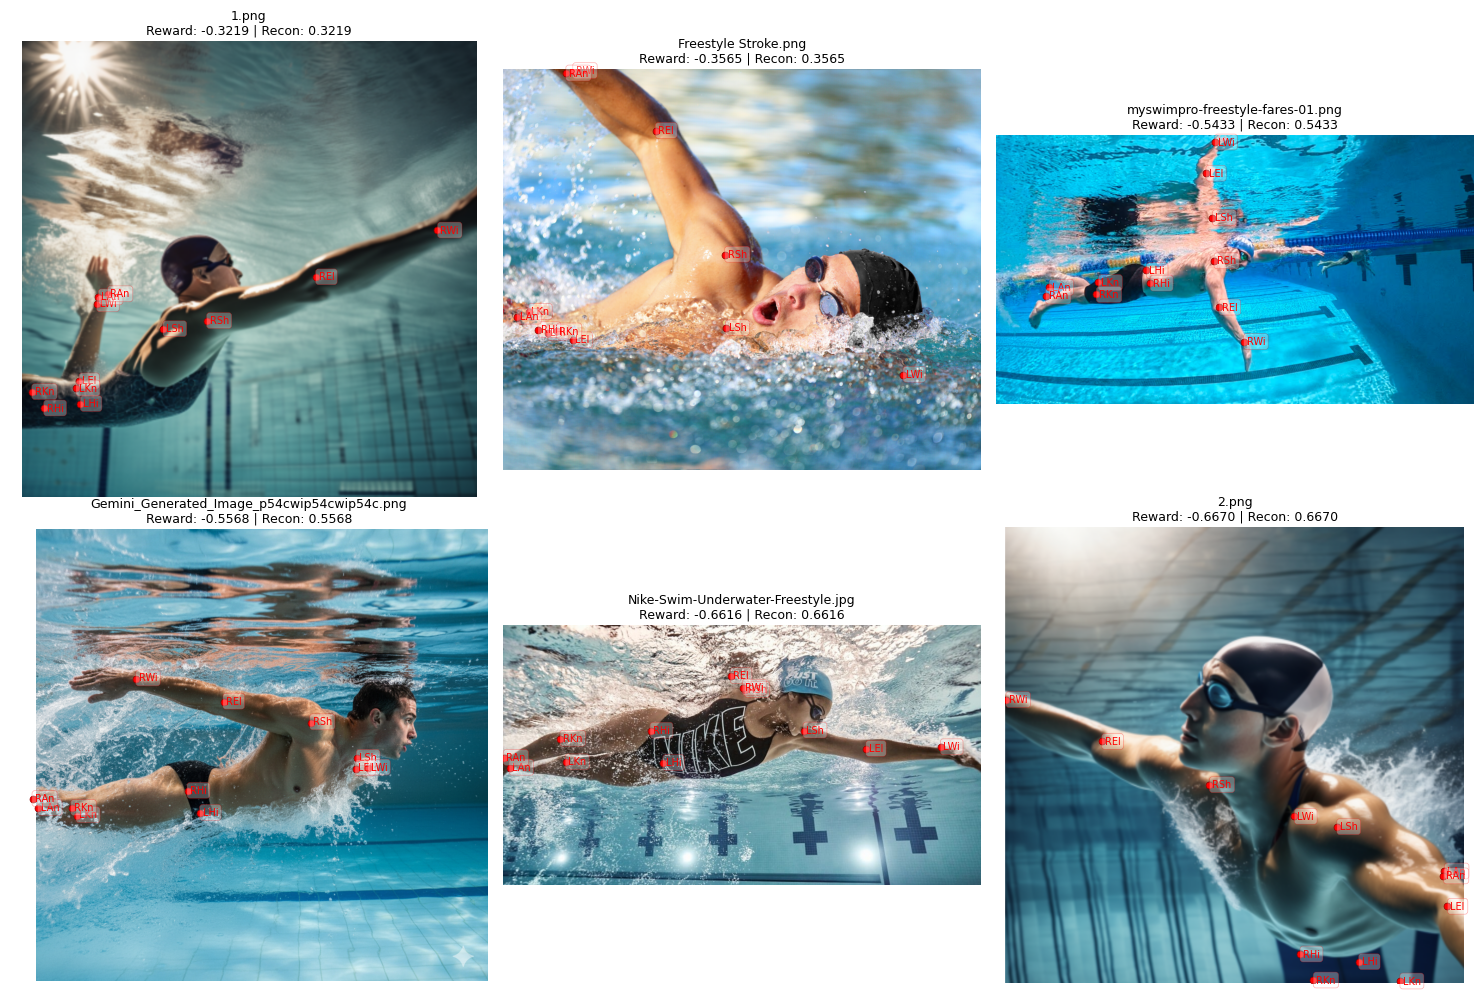


Bottom 6 results (worst poses):


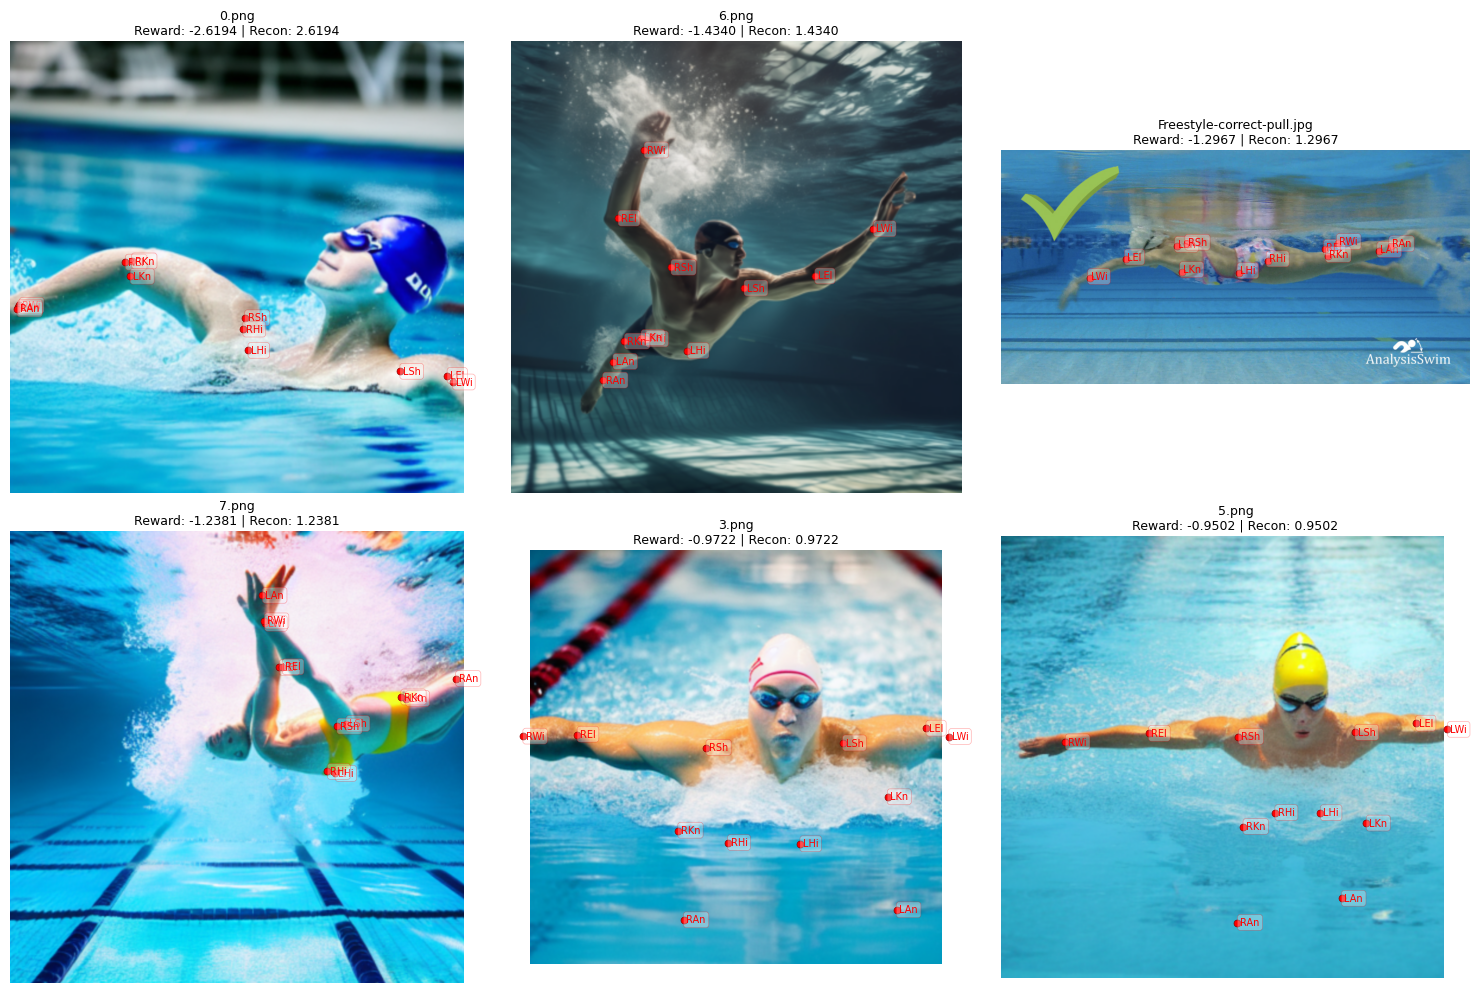

In [7]:
# Visualize top and bottom results
n_show = min(6, len(results))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

print(f"Top {n_show} results (best poses):")
for i in range(n_show):
    r = results[i]
    visualize_image_with_reward(
        r['path'], r['reward'], r['recon_loss'], r['keypoints'], axes[i]
    )

plt.tight_layout()
plt.show()

if len(results) > n_show:
    print(f"\nBottom {n_show} results (worst poses):")
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    axes2 = axes2.flatten()

    for i in range(n_show):
        r = results[-(i+1)]
        visualize_image_with_reward(
            r['path'], r['reward'], r['recon_loss'], r['keypoints'], axes2[i]
        )

    plt.tight_layout()
    plt.show()
